In [1]:
pip install xgboost lightgbm catboost optuna 

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [7]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm import tqdm

from functools import partial
import scipy as sp

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

from scipy.stats import rankdata
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier, LGBMRegressor 
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

import optuna 

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/PS-S3/Ep10/train.csv'
file_key_2 = 'Tabular-Playground-Series/PS-S3/Ep10/test.csv'
file_key_3 = 'Tabular-Playground-Series/PS-S3/Ep10/sample_submission.csv'
file_key_4 = 'Tabular-Playground-Series/PS-S3/Ep10/Pulsar.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

bucket_object_4 = bucket.Object(file_key_4)
file_object_4 = bucket_object_4.get()
file_content_stream_4 = file_object_4.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
train.drop(columns = 'id', axis = 1, inplace = True)
train['is_generated'] = 1

test = pd.read_csv(file_content_stream_2)
test['is_generated'] = 1

submission = pd.read_csv(file_content_stream_3)
original = pd.read_csv(file_content_stream_4)
original['is_generated'] = 0

train = pd.concat([train, original], axis = 0)

In [4]:
train.head()

,id,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,0,133.171875,59.716081,0.043133,-0.703383,54.917224,70.084438,0.749798,-0.649512,0
1,1,87.093750,36.257973,0.435469,2.266057,3.417224,21.865069,7.039330,52.686251,0
2,2,112.640625,39.818393,0.379639,0.922306,2.730769,15.689690,8.193471,85.649785,0
3,3,120.679688,45.918448,-0.098490,0.011775,2.696488,20.954662,8.183874,70.332899,0
4,4,134.070312,57.720107,-0.107772,-0.573335,1.107860,11.255051,16.107748,308.753765,0


In [5]:
original.head()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [9]:
X = train.drop(columns = ['Class'], axis = 1)
Y = train['Class']

test_baseline = test.drop(columns = ['id'], axis = 1)

GBC_md = GradientBoostingClassifier(n_estimators = 500, 
                                    max_depth = 3, 
                                    learning_rate = 0.01,
                                    min_samples_split = 2,
                                    min_samples_leaf = 2).fit(X, Y)

GBC_pred = GBC_md.predict_proba(test_baseline)[:, 1]
submission['Class'] = GBC_pred
submission.head()

,id,Class
0,117564,0.002462
1,117565,0.002979
2,117566,0.002526
3,117567,0.023201
4,117568,0.006362


In [10]:
X = train.drop(columns = ['Class'], axis = 1)
Y = train['Class']

test_baseline = test.drop(columns = ['id'], axis = 1)

GBC_md = GradientBoostingClassifier(n_estimators = 1000, 
                                    max_depth = 3, 
                                    learning_rate = 0.01,
                                    min_samples_split = 2,
                                    min_samples_leaf = 2).fit(X, Y)

lgb_md = LGBMClassifier(n_estimators = 1000,
                        max_depth = 3,
                        learning_rate = 0.01,
                        num_leaves = 20,
                        lambda_l1 = 3,
                        lambda_l2 = 3,
                        bagging_fraction = 0.7,
                        feature_fraction = 0.7).fit(X, Y)

xgb_md = XGBClassifier(tree_method = 'hist',
                       colsample_bytree = 0.7, 
                       gamma = 0.8, 
                       learning_rate = 0.01, 
                       max_depth = 7, 
                       min_child_weight = 10, 
                       n_estimators = 1000, 
                       subsample = 0.7).fit(X, Y)

cat_md = CatBoostClassifier(loss_function = 'Logloss',
                            iterations = 1000,
                            learning_rate = 0.01,
                            depth = 7,
                            random_strength = 0.5,
                            bagging_temperature = 0.7,
                            border_count = 30,
                            l2_leaf_reg = 5,
                            verbose = False, 
                            task_type = 'CPU').fit(X, Y)

GBC_pred = GBC_md.predict_proba(test_baseline)[:, 1]
lgb_pred = lgb_md.predict_proba(test_baseline)[:, 1]
xgb_pred = xgb_md.predict_proba(test_baseline)[:, 1]
cat_pred = cat_md.predict_proba(test_baseline)[:, 1]

ens_preds = 0.01*GBC_pred + 0.34*lgb_pred + 0.3*xgb_pred + 0.35*cat_pred
submission['Class'] = ens_preds
submission.head()

[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


,id,Class
0,117564,0.000219
1,117565,0.001484
2,117566,0.000320
3,117567,0.083668
4,117568,0.003932


In [13]:
ens_preds = (GBC_pred + lgb_pred + xgb_pred + cat_pred) / 4
submission['Class'] = ens_preds
submission.head()

,id,Class
0,117564,0.000434
1,117565,0.001724
2,117566,0.000556
3,117567,0.069054
4,117568,0.004013


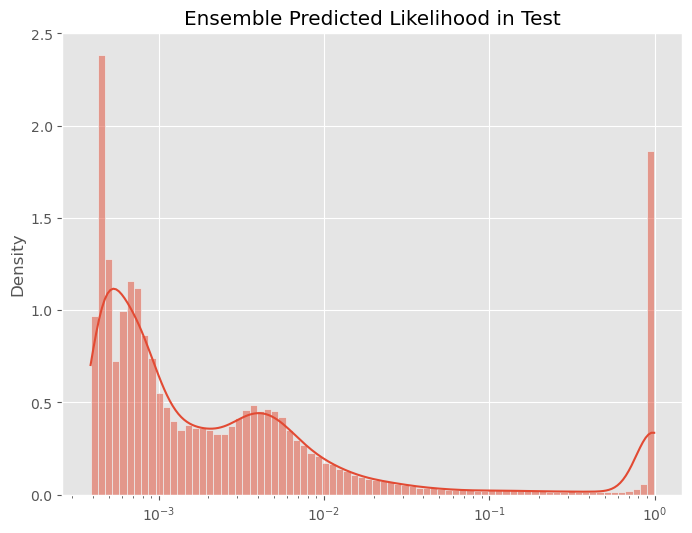

In [14]:
plt.figure(figsize = (8, 6))
sns.histplot(data = ens_preds, kde = True, stat = 'density', log_scale = True).set(title = 'Ensemble Predicted Likelihood in Test');

In [15]:
submission.to_csv('Ensemble_Baseline_full_submission_7.csv', index = False)